# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

#...현재 colab의 사용량 제한으로 인해 gpu 연결이 불가능 하다고 나옵니다.... ㅠ

torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [5]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                              


                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [6]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [7]:
# DataLoader

# batch-size = 4

train_loader =  DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader =  DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

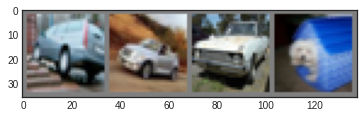

car	 car	 car	 dog	


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [10]:
from re import X
class Net(nn.Module):
     def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12,24,3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(24)
        self.maxpool1 = nn.MaxPool2d(2)
        #16
        self.conv4 = nn.Conv2d(24,48,3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(48)
        self.conv5 = nn.Conv2d(48,96,3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(96)
        self.maxpool2 = nn.MaxPool2d(2)
        #8
        self.conv6= nn.Conv2d(96,48, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(48)
        self.conv7= nn.Conv2d(48, 24, 3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(24)
        self.maxpool3 = nn.MaxPool2d(2,2)
        #4
        self.conv8= nn.Conv2d(24,48,3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(48)
        self.conv9= nn.Conv2d(48,96,3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm2d(96)
        self.conv10= nn.Conv2d(96,192,3, stride=1, padding=1)
        self.bn10 = nn.BatchNorm2d(192)
        self.maxpool4 = nn.MaxPool2d(2,2)
        #2
        self.fc1 = nn.Linear(192 * 2 * 2, 230)
        self.fc2 = nn.Linear(230, 115)
        self.dropout1 = nn.Dropout2d(p=0.5, inplace=False)
        self.fc3 = nn.Linear(115, 10)
       
      
     def forward(self, x):
       
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.maxpool2(x)
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.maxpool3(x)
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = self.maxpool4(x)
       
        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의
     
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.fc3(x)
       

        return x
    
     def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

net = Net()


In [11]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [12]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [13]:
#output; (4 * 10)

output = myNet.forward(input)
output.size()

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


torch.Size([4, 10])

In [14]:
# 모델 구조 확인

summary(myNet, input_size=(3,32,32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [4, 6, 32, 32]             168
       BatchNorm2d-2             [4, 6, 32, 32]              12
            Conv2d-3            [4, 12, 32, 32]             660
       BatchNorm2d-4            [4, 12, 32, 32]              24
            Conv2d-5            [4, 24, 32, 32]           2,616
       BatchNorm2d-6            [4, 24, 32, 32]              48
         MaxPool2d-7            [4, 24, 16, 16]               0
            Conv2d-8            [4, 48, 16, 16]          10,416
       BatchNorm2d-9            [4, 48, 16, 16]              96
           Conv2d-10            [4, 96, 16, 16]          41,568
      BatchNorm2d-11            [4, 96, 16, 16]             192
        MaxPool2d-12              [4, 96, 8, 8]               0
           Conv2d-13              [4, 48, 8, 8]          41,520
      BatchNorm2d-14              [4, 4

## 손실함수와 옵티마이저

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

In [16]:
# epochs = 20

for epoch in range(20):
    running_loss = 0.0

    for i, data in enumerate(train_loader, start= 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()                            # 가중치 초기화

        outputs = myNet(inputs)                          # y_pred
        loss = criterion(outputs, labels)                           # 손실함수를 이용해서 loss계산
        loss.backward()                           # back-propagation
        optimizer.step()                          # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.0215257987082005
Epoch: 1, Batch: 4000, Loss: 1.7724230817556381
Epoch: 1, Batch: 6000, Loss: 1.5990177331119775
Epoch: 1, Batch: 8000, Loss: 1.4755794483572244
Epoch: 1, Batch: 10000, Loss: 1.4140097985714675
Epoch: 1, Batch: 12000, Loss: 1.3006333419606089
Epoch: 2, Batch: 2000, Loss: 1.2184122495702467
Epoch: 2, Batch: 4000, Loss: 1.161942129294388
Epoch: 2, Batch: 6000, Loss: 1.133296302743256
Epoch: 2, Batch: 8000, Loss: 1.1121061574947089
Epoch: 2, Batch: 10000, Loss: 1.0624382329322397
Epoch: 2, Batch: 12000, Loss: 1.048385901235044
Epoch: 3, Batch: 2000, Loss: 0.9774634083472192
Epoch: 3, Batch: 4000, Loss: 0.9564923711526208
Epoch: 3, Batch: 6000, Loss: 0.9342814836697653
Epoch: 3, Batch: 8000, Loss: 0.9227521100465674
Epoch: 3, Batch: 10000, Loss: 0.8979896354451775
Epoch: 3, Batch: 12000, Loss: 0.915853270758409
Epoch: 4, Batch: 2000, Loss: 0.832104793306964
Epoch: 4, Batch: 4000, Loss: 0.8418639266896062
Epoch: 4, Batch: 6000, Loss: 0.83534313

## 모델의 저장 및 로드

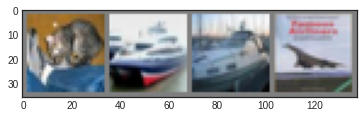

	cat 	ship 	ship 	plane


In [28]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [29]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [30]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [34]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                              # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                                             # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

79.09


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [27]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 82.5%
Accuracy of car: 88.3%
Accuracy of bird: 68.3%
Accuracy of cat: 67.6%
Accuracy of deer: 74.1%
Accuracy of dog: 61.4%
Accuracy of frog: 86.6%
Accuracy of horse: 84.6%
Accuracy of ship: 86.3%
Accuracy of truck: 89.6%


In [22]:
#이놈의 개랑 고양이가 구별이 안되서 70%를 못넘기겠습니다.....!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!